# Introduction to deep learning for computer vision

### Downloading the data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arbudasivanimajeti","key":"c7cb92f51d4c2c974d1346c4590415c8"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle competitions download -c dogs-vs-cats

 97% 791M/812M [00:04<00:00, 221MB/s]
100% 812M/812M [00:04<00:00, 183MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

#Model - 1:
 Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

**Copying images to training, validation, and test directories**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Building the model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Fitting the model using a `Dataset`**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 5s 72ms/step - loss: 0.0706 - accuracy: 0.9835 - val_loss: 5.3993 - val_accuracy: 0.7640
Epoch 2/50
63/63 [==============================] - 5s 70ms/step - loss: 0.1101 - accuracy: 0.9860 - val_loss: 3.9045 - val_accuracy: 0.7770
Epoch 3/50
63/63 [==============================] - 5s 70ms/step - loss: 0.0275 - accuracy: 0.9950 - val_loss: 5.3706 - val_accuracy: 0.7560
Epoch 4/50
63/63 [==============================] - 5s 69ms/step - loss: 0.0616 - accuracy: 0.9895 - val_loss: 5.4420 - val_accuracy: 0.7640
Epoch 5/50
63/63 [==============================] - 5s 70ms/step - loss: 0.0894 - accuracy: 0.9890 - val_loss: 4.0928 - val_accuracy: 0.7560
Epoch 6/50
63/63 [==============================] - 5s 69ms/step - loss: 0.0582 - accuracy: 0.9920 - val_loss: 5.3236 - val_accuracy: 0.6930
Epoch 7/50
63/63 [==============================] - 5s 69ms/step - loss: 0.0716 - accuracy: 0.9895 - val_loss: 4.0187 - val_accuracy: 0.7540
Epoch 8/50
63

**Displaying curves of loss and accuracy during training**

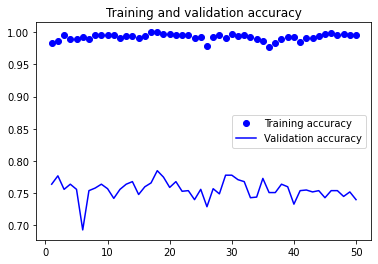

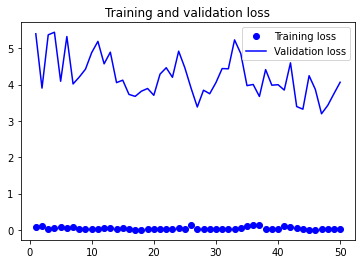

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 34ms/step - loss: 3.5251 - accuracy: 0.7410
Test accuracy: 0.741


#Model - 2: 
Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

**Define a data augmentation stage to add to an image model**

In [ ]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

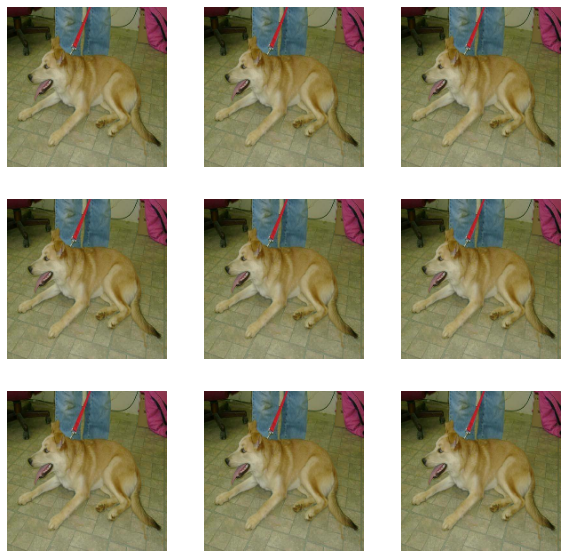

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 96ms/step - loss: 0.7631 - accuracy: 0.5015 - val_loss: 0.6921 - val_accuracy: 0.5010
Epoch 2/50
63/63 [==============================] - 6s 93ms/step - loss: 0.7028 - accuracy: 0.5250 - val_loss: 0.6885 - val_accuracy: 0.5540
Epoch 3/50
63/63 [==============================] - 6s 95ms/step - loss: 0.7038 - accuracy: 0.5260 - val_loss: 0.6808 - val_accuracy: 0.5210
Epoch 4/50
63/63 [==============================] - 6s 92ms/step - loss: 0.6995 - accuracy: 0.5695 - val_loss: 0.6558 - val_accuracy: 0.6070
Epoch 5/50
63/63 [==============================] - 6s 93ms/step - loss: 0.6739 - accuracy: 0.5655 - val_loss: 0.6453 - val_accuracy: 0.6010
Epoch 6/50
63/63 [==============================] - 6s 92ms/step - loss: 0.6629 - accuracy: 0.6210 - val_loss: 0.6498 - val_accuracy: 0.5890
Epoch 7/50
63/63 [==============================] - 6s 97ms/step - loss: 0.6383 - accuracy: 0.6340 - val_loss: 0.7161 - val_accuracy: 0.5690
Epoch 8/50
63

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 34ms/step - loss: 0.4643 - accuracy: 0.8120
Test accuracy: 0.812


#Model - 3: 
Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.


In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

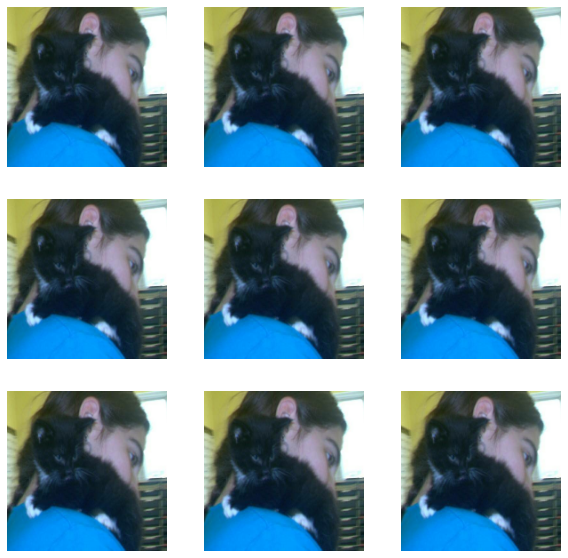

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 9s 142ms/step - loss: 0.2557 - accuracy: 0.8995 - val_loss: 0.5822 - val_accuracy: 0.7820
Epoch 2/50
63/63 [==============================] - 10s 147ms/step - loss: 0.2584 - accuracy: 0.8920 - val_loss: 0.5348 - val_accuracy: 0.8250
Epoch 3/50
63/63 [==============================] - 6s 93ms/step - loss: 0.2486 - accuracy: 0.9025 - val_loss: 0.6581 - val_accuracy: 0.8120
Epoch 4/50
63/63 [==============================] - 6s 93ms/step - loss: 0.2367 - accuracy: 0.8955 - val_loss: 0.5810 - val_accuracy: 0.8250
Epoch 5/50
63/63 [==============================] - 6s 91ms/step - loss: 0.2287 - accuracy: 0.9120 - val_loss: 0.6427 - val_accuracy: 0.8430
Epoch 6/50
63/63 [==============================] - 6s 96ms/step - loss: 0.2610 - accuracy: 0.8975 - val_loss: 0.4979 - val_accuracy: 0.8340
Epoch 7/50
63/63 [==============================] - 6s 92ms/step - loss: 0.2260 - accuracy: 0.9030 - val_loss: 0.4996 - val_accuracy: 0.8370
Epoch 8/50

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 53ms/step - loss: 0.5215 - accuracy: 0.8260
Test accuracy: 0.826


#Model - 4:
Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 19ms/step


In [ ]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 18ms/step - loss: 17.1352 - accuracy: 0.9225 - val_loss: 7.3274 - val_accuracy: 0.9450
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 3.4957 - accuracy: 0.9785 - val_loss: 6.0471 - val_accuracy: 0.9610
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2.2232 - accuracy: 0.9830 - val_loss: 7.7548 - val_accuracy: 0.9670
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.7005 - accuracy: 0.9900 - val_loss: 3.4450 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.9089 - accuracy: 0.9920 - val_loss: 4.2232 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 0.9305 - accuracy: 0.9950 - val_loss: 3.2892 - val_accuracy: 0.9800
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6294 - accuracy: 0.9955 - val_loss: 3.5947 - val_accuracy: 0.9750
Epoch 8/20
63/63 [

**Plotting the results**

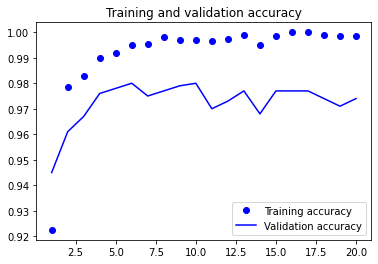

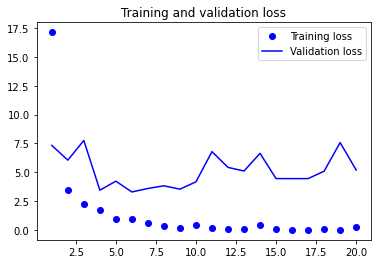

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 14s 193ms/step - loss: 19.5853 - accuracy: 0.8925 - val_loss: 3.7849 - val_accuracy: 0.9700
Epoch 2/50
63/63 [==============================] - 12s 191ms/step - loss: 5.2515 - accuracy: 0.9500 - val_loss: 6.2741 - val_accuracy: 0.9650
Epoch 3/50
63/63 [==============================] - 12s 190ms/step - loss: 6.4387 - accuracy: 0.9520 - val_loss: 12.6900 - val_accuracy: 0.9490
Epoch 4/50
63/63 [==============================] - 13s 195ms/step - loss: 4.9638 - accuracy: 0.9590 - val_loss: 2.7881 - val_accuracy: 0.9780
Epoch 5/50
63/63 [==============================] - 12s 192ms/step - loss: 5.1014 - accuracy: 0.9600 - val_loss: 3.6170 - val_accuracy: 0.9770
Epoch 6/50
63/63 [==============================] - 12s 191ms/step - loss: 4.1108 - accuracy: 0.9715 - val_loss: 3.6695 - val_accuracy: 0.9780
Epoch 7/50
63/63 [==============================] - 12s 194ms/step - loss: 3.2773 - accuracy: 0.9670 - val_loss: 7.1992 - val_accuracy: 0.96

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 117ms/step - loss: 2.6057 - accuracy: 0.9780
Test accuracy: 0.978


**A pretrained VGG16 model with Fine-tuning**

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all the layers except the last fourth one**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine Tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 243ms/step - loss: 0.2985 - accuracy: 0.9905 - val_loss: 1.1205 - val_accuracy: 0.9850
Epoch 2/30
63/63 [==============================] - 15s 241ms/step - loss: 0.4596 - accuracy: 0.9910 - val_loss: 1.4931 - val_accuracy: 0.9820
Epoch 3/30
63/63 [==============================] - 15s 236ms/step - loss: 0.1823 - accuracy: 0.9940 - val_loss: 1.7751 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 15s 234ms/step - loss: 0.1019 - accuracy: 0.9965 - val_loss: 1.4731 - val_accuracy: 0.9810
Epoch 5/30
63/63 [==============================] - 15s 229ms/step - loss: 0.5098 - accuracy: 0.9860 - val_loss: 1.3598 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 15s 233ms/step - loss: 0.4768 - accuracy: 0.9880 - val_loss: 1.5014 - val_accuracy: 0.9800
Epoch 7/30
63/63 [==============================] - 15s 233ms/step - loss: 0.5004 - accuracy: 0.9905 - val_loss: 1.4305 - val_accuracy: 0.9820

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 116ms/step - loss: 1.5497 - accuracy: 0.9800
Test accuracy: 0.980


**Summary**

**•	Model-1:**

o	Test Accuracy: 74% and loss: 3.52

o	Training sample = 1000, Validation sample = 500, Test sample = 500

o	Method to reduce overfitting: Regularization

o	*Conclusion:*
	The accuracy in the initial model without any regularization was 71%. Then I tried to change the optimizer to Adam instead of rmsprop with 30 epochs and Dropout, the test accuracy cameout to be 68.3% and loss is 0.61. Finally, I ran a model with 50 epochs and Adam then the test accuracy is 74%.

**•	Model – 2:**

o	Test Accuracy: 82% and loss: 0.42

o	Training sample = 1500  Validation sample = 500, Test sample = 500

o	Methods: Regularization and Data Augmentation

o*	Conclusion:*
	I tried a model with Adam, Data Augmentation and regularization and 50 epochs the accuracy of the model was 78% and loss was 0.49. The final model had rms prop as an optimizer and the final accuracy was 81% and loss was 0.46. The result obtained was better than the model with only regularization.

**•	Model – 3:**

o	Test Accuracy: 83% and loss: 0.52

o	Training sample = 2000 , Validation sample = 500 and Test sample = 500

o	Methods: Regularization and Data Augmentation

*o	Conclusion:*
	Increased the training sample to 2000 and the training and validation sample remain the same. Initially, I ran a model with the same metrics but Adam as an optimizer then the accuracy was 76% and loss was 0.52. Then changed the optimizer to rmsprop then I achieved better results with accuracy as 83% and loss as 0.52

**•	Model – 4:**

o	VGG16 Pretrained Convnet Network

o	Without data augmentation:
	Test Accuracy: 98% and loss: 1.55

	Using a pretrained model to apply deep learning to tiny image datasets is a highly effective method. A pretrained model is one that has been trained earlier on a big dataset, usually for a large – scale image classification problem. 

	Fine tuning the model was to unfreeze the top layers of the frozen model for feature extraction and training. It is more on to adjusting the representations of the model.

	There were three different scenarios considered while running the model
•	Pre – trained model with Data Augmentation
•	Pre – trained model without Data Augmentation
•	Pre – trained model with fine tuning

	Pre-trained model with fine tuning had a test accuracy of 98% 
whereas, Pre – trained model with Data Augmentation has a test accuracy of 97%

*Conclusion:*
Using a pretrained model to apply deep learning techniques proves to be much more effective than training a model from scratch. 

